In [ ]:
# Basic med de 5 algoene

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
test_X_pls = X_pls[len(train_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
test_X_rfe = X_rfe[len(train_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    # Optimized Random Forest Regressor
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions and store MSE values for each model
predictions = {}
mse_values = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
            model.fit(train_X_rfe, train_y)
    
    predictions[name] = pred
    
    # Calculate MSE for each model and store it in mse_values dictionary
    mse_values[name] = mean_squared_error(test_y, pred)

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Calculate and display RMSE for each model and print MSE values for bar chart plotting
for name in predictions.keys():
    rmse = np.sqrt(mse_values[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(list(mse_values.keys()), list(mse_values.values()), color='orange')

plt.title('Mean Squared Error (MSE) of Different Algorithms')
plt.ylabel('Mean Squared Error')
plt.xlabel('Algorithms')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom')  # Position the text at the center of the bar and just above it

plt.show()

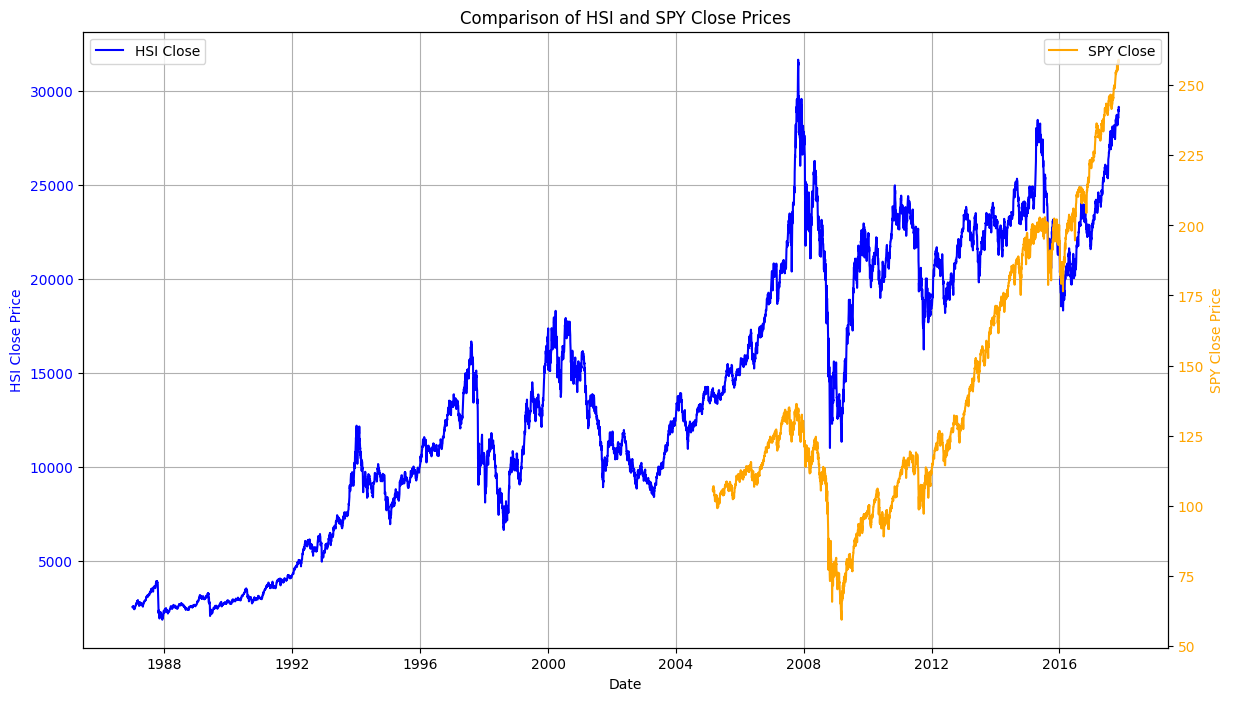

In [39]:
# HSI vs SP500

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Load DJI data using Yahoo Finance
ticker = yf.Ticker('^HSI')
hist = ticker.history(period="max")
hist = hist[['Open', 'High', 'Low', 'Close']].dropna()

# Load SPY data from CSV
df_spy = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert the 'Date' column in df_spy to datetime format
df_spy['Date'] = pd.to_datetime(df_spy['Date'])

# Set the 'Date' column as the index for both dataframes
df_spy.set_index('Date', inplace=True)

# Convert hist index to datetime and ensure timezone alignment
hist.index = pd.to_datetime(hist.index)

# Apply a rolling average to smooth out the DJI data
hist['Close_Smoothed'] = hist['Close'].rolling(window=1).mean()

# Trim data to the desired range
hist_trimmed = hist[(hist.index <= '2017-11-10')]
df_spy_trimmed = df_spy[(df_spy.index >= '2000-01-01')]

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the smoothed DJI Close Price on the left y-axis
ax1.plot(hist_trimmed.index, hist_trimmed['Close_Smoothed'], label="HSI Close", color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('HSI Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the SPY Close Price
ax2 = ax1.twinx()
ax2.plot(df_spy_trimmed.index, df_spy_trimmed['Close'], label="SPY Close", color='orange')
ax2.set_ylabel('SPY Close Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add titles and grid to the main plot
ax1.set_title('Comparison of HSI and SPY Close Prices')
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


Epoch 1/10


c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0042
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 3.2915e-04
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 2.5903e-04
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 2.1217e-04
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 1.9126e-04
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 1.8492e-04
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 1.6917e-04
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1.5101e-04
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.5002e-04
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 1.3335e-04
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.1631e-06
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.1318e-08
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.1779e-08
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.2179e-08
Epoch 

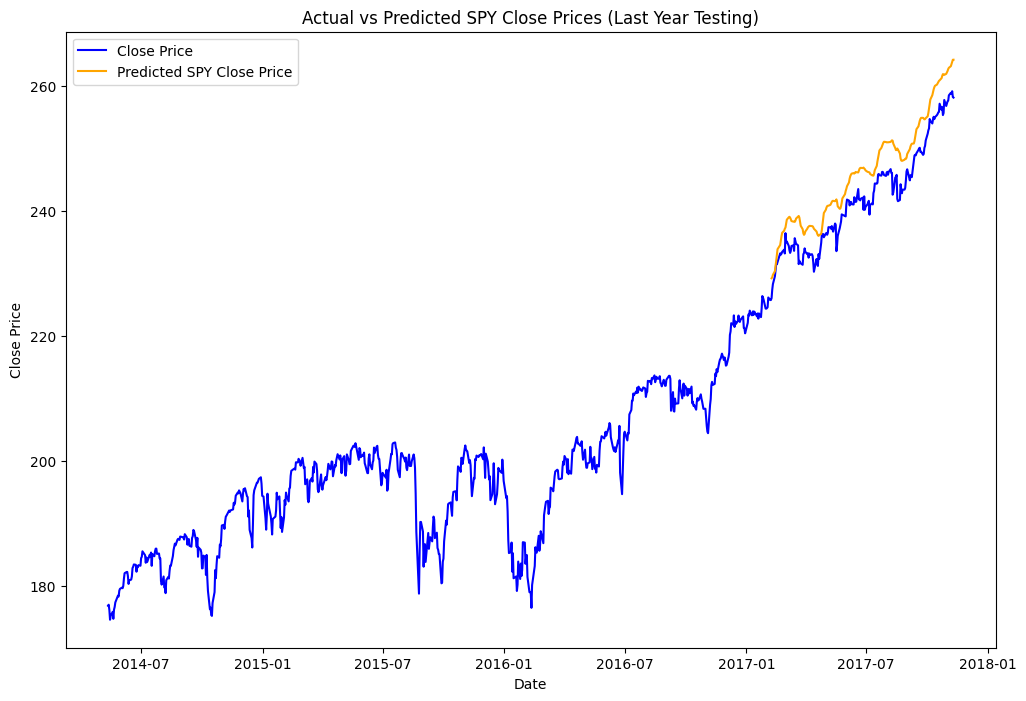

In [91]:
# transefer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# Function to load and preprocess data with specific columns only
def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    # Keep only the required columns
    hist = hist[['Open', 'High', 'Low', 'Close']].dropna()
    
    # Filter data by date range if specified
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]
    
    return hist

# Load SPY data and define the date range for the last year (testing data)
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)  # Approximate one year

# Load DJI data for pretraining up to the start of the SPY testing period
dji_data = load_and_preprocess_data("^HSI", end_date=spy_test_start_date)

# Scale both datasets using the same scaler
scaler = MinMaxScaler()
dji_data_scaled = scaler.fit_transform(dji_data)
spy_data_scaled = scaler.transform(spy_data)

# Helper function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # 'Close' is at index 3 after selecting columns
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM input
seq_length = 60
dji_X, dji_y = create_sequences(dji_data_scaled, seq_length)

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and pretrain the LSTM model on DJI data
lstm_model = create_lstm_model((dji_X.shape[1], dji_X.shape[2]))
lstm_model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)

# Split SPY data into training (up to test start) and testing (last year)
spy_train_data = spy_data[spy_data.index < spy_test_start_date]
spy_test_data = spy_data[spy_data.index >= spy_test_start_date]

# Scale SPY training and testing data using the same scaler
spy_train_scaled = scaler.transform(spy_train_data)
spy_test_scaled = scaler.transform(spy_test_data)

# Create sequences for SPY training and testing data
spy_X_train, spy_y_train = create_sequences(spy_train_scaled, seq_length)
spy_X_test, spy_y_test = create_sequences(spy_test_scaled, seq_length)

# Fine-tune the pretrained model on SPY training data
lstm_model.fit(spy_X_train, spy_y_train, epochs=10, batch_size=32, verbose=1)

# Generate predictions on SPY testing data
spy_predictions_scaled = lstm_model.predict(spy_X_test)
spy_predictions = scaler.inverse_transform(np.hstack((np.zeros((spy_predictions_scaled.shape[0], 3)), spy_predictions_scaled)))[:, -1]

# Inverse scale the actual test values for comparison
spy_y_test_true = scaler.inverse_transform(np.hstack((np.zeros((spy_y_test.reshape(-1, 1).shape[0], 3)), spy_y_test.reshape(-1, 1))))[:, -1]

# Calculate Mean Squared Error for the test period
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")

# Plot actual vs predicted SPY Close prices for the testing period
plt.figure(figsize=(12, 8))
last_3_years = spy_data.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = spy_data[spy_data.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="orange")
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

LSTM Model MSE on SPY Test Data (Last Year): 20.10128378378606


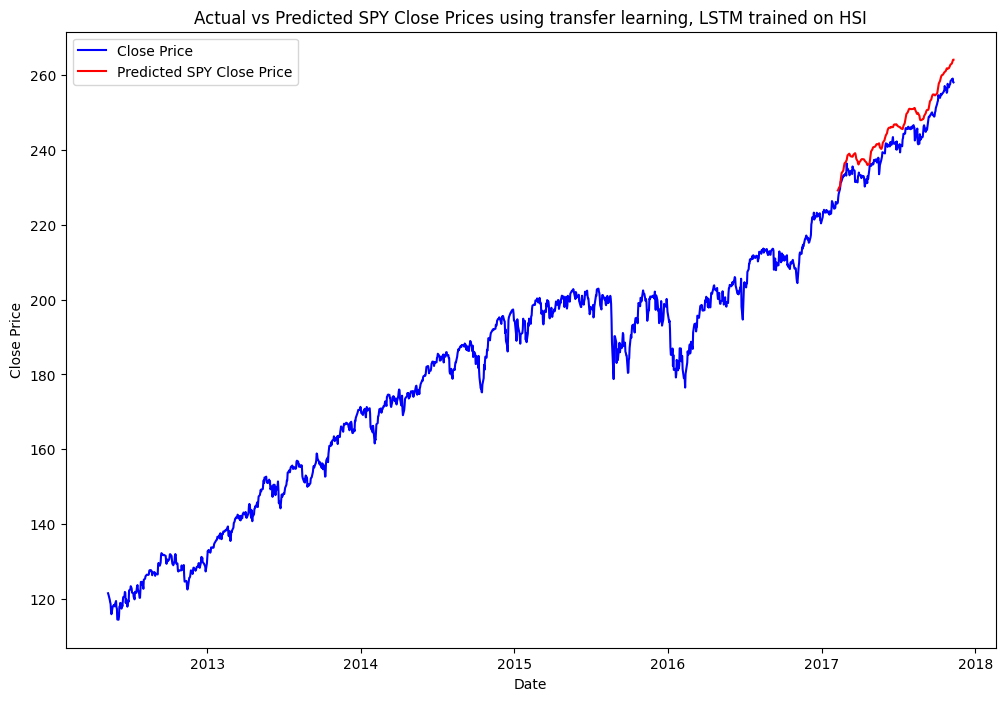

In [ ]:
# transfer mer plotting

# Plot actual vs predicted SPY Close prices for the testing period
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
plt.figure(figsize=(12, 8))
last_3_years = spy_data.index[-1] - pd.DateOffset(months=5 * 12 + 6)
df_last_3_years = spy_data[spy_data.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="red")
plt.title("Actual vs Predicted SPY Close Prices using transfer learning, LSTM trained on HSI")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
import xgboost as xgb
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

##################################################################

df = pd.read_csv("spy.us.txt")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.info()

X = df.drop(columns=["Close"])
y = df["Close"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##################################################################


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE


def create_date_features(df):
    df["DayOfYear"] = df.index.dayofyear
    df["WeekOfYear"] = df.index.isocalendar().week
    df["Month"] = df.index.month
    df["Year"] = df.index.year

    # Sine-cosine encoding for cyclical features
    df["DayOfYear_sin"] = np.sin(2 * np.pi * df["DayOfYear"] / 365.25)
    df["DayOfYear_cos"] = np.cos(2 * np.pi * df["DayOfYear"] / 365.25)
    df["WeekOfYear_sin"] = np.sin(2 * np.pi * df["WeekOfYear"] / 52)
    df["WeekOfYear_cos"] = np.cos(2 * np.pi * df["WeekOfYear"] / 52)
    df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    return df


# Load the data
df = pd.read_csv("spy.us.txt")

# Convert Date column to datetime and set it as the index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[f"{col}_lag_{i}"] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df["Close"]
features = [col for col in df.columns if col != "Close"]
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(
    np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2)
)
n_components = (
    np.argmax(cumulative_variance >= 0.95) + 1
)  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[: len(train_X)]
test_X_pls = X_pls[len(train_X) 🙂

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[: len(train_X)]
test_X_rfe = X_rfe[len(train_X) 🙂

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Additive Model": LinearGAM(
        s(0) + s(1) + s(2) + s(3) + s(4),
        fit_intercept=True,
        max_iter=100,
        tol=0.0001,
        verbose=False,
        callbacks=None,  # Ensure callbacks is set to None
    ),
    "SVR": SVR(kernel="linear", C=100, epsilon=5),
    # Optimized Random Forest Regressor
    "Random Forest": RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features="sqrt",
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01
    ),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model="additive", period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions and store MSE values for each model
predictions = {}
mse_values = {}
for name, model in models.items():
    if name == "Linear Regression":
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X) 🙂
    else:
        model.fit(train_X_rfe, train_y if name == "Additive Model" else train_y)
        pred = model.predict(test_X_rfe)
        if name == "Additive Model":
            model.fit(train_X_rfe, train_y)

    predictions[name] = pred

    # Calculate MSE for each model and store it in mse_values dictionary
    mse_values[name] = mean_squared_error(test_y, pred)

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df["Actual"] = test_y

# Calculate and display RMSE for each model and print MSE values for bar chart plotting
for name in predictions.keys():
    rmse = np.sqrt(mse_values[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(
    df_last_3_years.index, df_last_3_years["Close"], label="Close Price", color="blue"
)

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(list(mse_values.keys()), list(mse_values.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Different Algorithms")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position the text at the center of the bar and just above it

plt.show()


##################################################################


from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Initialize dictionaries to store bagged predictions and MSE values
bagpred = {}
bagmse = {}


class GAMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = LinearGAM(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.model.get_params()

    def set_params(self, **params):
        self.model.set_params(**params)
        return self


bagging_model = BaggingRegressor(
    estimator=GAMWrapper(
        model=LinearGAM(
        s(0) + s(1) + s(2) + s(3) + s(4),
        fit_intercept=True,
        max_iter=100,
        tol=0.0001,
        verbose=False,
        callbacks=None,  # Set callbacks to None
    )),
    n_estimators=50,
    random_state=42,
)
bagging_model.fit(train_X_rfe, train_y)  # Fit on training data
pred = bagging_model.predict(test_X_rfe)  # Predict on test data
bagpred["Bagging " + "Additive Model"] = pred
bagmse["Bagging " + "Additive Model"] = mean_squared_error(test_y, pred)

# # Loop through each model in the models dictionary
# for name, model in models.items():
#     if name == "Linear Regression":
#         # For Linear Regression, we can directly bag it
#         bagging_model = BaggingRegressor(
#             estimator=model,  # Use Linear Regression as the base estimator
#             n_estimators=50,  # Number of base estimators
#             random_state=42,
#         )
#         bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

#         # Generate predictions on test set
#         pred = bagging_model.predict(test_X_rfe)

#     elif name == "Additive Model":
#         continue  # Skip Additive Model as it's not a regression model

#     else:
#         # For other models, wrap them in a Bagging Regressor
#         bagging_model = BaggingRegressor(
#             estimator=model,  # Base estimator
#             n_estimators=50,  # Number of base estimators
#             random_state=42,
#         )
#         bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

#         # Generate predictions on test set
#         pred = bagging_model.predict(test_X_rfe)

#     # Store predictions and MSE values for each bagged model
#     bagpred["Bagging " + name] = pred
#     bagmse["Bagging " + name] = mean_squared_error(test_y, pred)


# boostpred = {}
# boostmse = {}
# boosted_model = AdaBoostRegressor(
#             estimator=models["SVR"], n_estimators=50, random_state=42
#         )
# boosted_model.fit(train_X_rfe, train_y)  # Fit on training data
# pred = boosted_model.predict(test_X_rfe)  # Predict on test data
# boostpred["Boosting " + "SVR"] = pred
# boostmse["Boosting " + "SVR"] = mean_squared_error(test_y, pred)
# for name, model in models.items():
#     if name == "Additive Model":
#         continue  # Skip if model should not be boosted
#     else:
#         # Use AdaBoost for all models directly
#         boosted_model = AdaBoostRegressor(
#             estimator=model, n_estimators=50, random_state=42
#         )
#         boosted_model.fit(train_X_rfe, train_y)  # Fit on training data
#         pred = boosted_model.predict(test_X_rfe)  # Predict on test data

#     # Store predictions and MSE for each boosted model
#     boostpred["Boosting " + name] = pred
#     boostmse["Boosting " + name] = mean_squared_error(test_y, pred)


# Plot actual vs. predicted prices including Bagged Linear Regression model
plt.figure(figsize=(12, 8))
plt.plot(
    df_last_3_years.index, df_last_3_years["Close"], label="Close Price", color="blue"
)

# Plot each model's predictions including Bagged models
for name, pred in bagpred.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Bagged Models)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE values for Bagged models
plt.figure(figsize=(10, 6))
bars = plt.bar(list(bagmse.keys()), list(bagmse.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Bagged Algorithms")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position text at center of bar
    
plt.show()